# 01.1 Potential Outcomes Framework

**Chapter**: 1 - Introduction to Causality  
**Section**: 1 - Potential Outcomes Framework  
**Facure Source**: 01-Introduction-To-Causality.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [Why Bother with Causality?](#11-why-bother-with-causality)
   - 1.2 [The Fundamental Problem](#12-the-fundamental-problem)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Potential Outcomes Notation](#21-potential-outcomes-notation)
   - 2.2 [Treatment Effects: ITE, ATE, ATT](#22-treatment-effects-ite-ate-att)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Tablets in Schools Example](#31-tablets-in-schools-example)
   - 3.2 [Observing Missing Counterfactuals](#32-observing-missing-counterfactuals)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm,
    set_notebook_style,
    create_tufte_figure,
    TUFTE_PALETTE,
)
from scipy.special import expit

set_notebook_style()
np.random.seed(42)

---

## 1. Facure's Intuition

> **Interview Relevance**: The potential outcomes framework (Rubin Causal Model) is the lingua franca of causal inference. Every tech company expects candidates to articulate causal questions using this notation.

### 1.1 Why Bother with Causality?

As Facure eloquently puts it, Machine Learning excels at *prediction* but struggles with *counterfactual* questions:

- **Prediction**: "Given these features, what's the likely outcome?"
- **Causal**: "What would happen *if* we changed this feature?"

The causal question requires understanding **what would have happened** under a different intervention—the road not taken.

> *"Two roads diverged in a yellow wood, / And sorry I could not travel both..."*  
> — Robert Frost

**Examples of causal questions**:
- Does giving tablets to students improve test scores?
- Does a college degree cause higher earnings?
- Does the new UI increase conversions?

### 1.2 The Fundamental Problem

The **fundamental problem of causal inference**[^1] is that we can never observe the same unit with *and* without treatment.

- Student $i$ either gets a tablet or doesn't
- We see their score under *one* condition
- The counterfactual outcome remains forever unknown

This is not a statistical problem—it's a logical impossibility. No amount of data can reveal what *would have been*.

★ Insight ─────────────────────────────────────
- The fundamental problem is **philosophical**, not statistical
- We can estimate *average* effects across units
- All causal inference methods are strategies to infer the missing counterfactual
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Potential Outcomes Notation

For each unit $i$, define:

**Treatment indicator**:
$$T_i = \begin{cases} 1 & \text{if unit } i \text{ receives treatment} \\ 0 & \text{otherwise} \end{cases}$$

**Potential outcomes**:
- $Y_{0i}$: outcome for unit $i$ *if* untreated (control potential outcome)
- $Y_{1i}$: outcome for unit $i$ *if* treated (treated potential outcome)

**Key insight**: Both $Y_{0i}$ and $Y_{1i}$ exist conceptually for every unit, regardless of actual treatment.

**Observed outcome**:
$$Y_i = Y_{0i}(1-T_i) + Y_{1i}T_i = \begin{cases} Y_{1i} & \text{if } T_i = 1 \\ Y_{0i} & \text{if } T_i = 0 \end{cases}$$

Alternative notation: $Y_i = Y_i(T_i)$ as a function of treatment.

### 2.2 Treatment Effects: ITE, ATE, ATT

**Individual Treatment Effect (ITE)**:
$$\tau_i = Y_{1i} - Y_{0i}$$

The ITE is *never observable*—we only see one potential outcome.

**Average Treatment Effect (ATE)**:
$$\text{ATE} = E[Y_1 - Y_0] = E[Y_1] - E[Y_0]$$

The ATE averages over the *entire population*, including those who would never receive treatment.

**Average Treatment Effect on the Treated (ATT)**:
$$\text{ATT} = E[Y_1 - Y_0 | T=1]$$

The ATT focuses on those who *actually* received treatment—often the policy-relevant estimand.

**Relationship**:
$$\text{ATE} = P(T=1) \cdot \text{ATT} + P(T=0) \cdot \text{ATU}$$

where ATU = Average Treatment Effect on the Untreated.

| Estimand | Formula | Interpretation |
|----------|---------|----------------|
| ITE | $\tau_i = Y_{1i} - Y_{0i}$ | Effect for individual $i$ (unobservable) |
| ATE | $E[Y_1 - Y_0]$ | Average effect across population |
| ATT | $E[Y_1 - Y_0 \| T=1]$ | Average effect among treated |

---

## 3. Numeric Demonstration

### 3.1 Tablets in Schools Example

Facure's setup: Schools may provide tablets to students. Do tablets improve test scores?

In [2]:
# Simulate God's-eye view: we know both potential outcomes
# (In reality, we'd never have this!)

schools = pd.DataFrame({
    'school_id': [1, 2, 3, 4],
    'Y0': [500, 600, 800, 700],  # Score without tablets
    'Y1': [450, 600, 600, 750],  # Score with tablets
    'T':  [0, 0, 1, 1],          # Actual treatment
})

# Calculate treatment effects
schools['tau_i'] = schools['Y1'] - schools['Y0']  # Individual TE
schools['Y_obs'] = np.where(schools['T'] == 1, schools['Y1'], schools['Y0'])

print("GOD'S-EYE VIEW (Both Potential Outcomes Observed)")
print("="*60)
print(schools.to_string(index=False))
print()
print(f"ATE = E[Y1 - Y0] = {schools['tau_i'].mean():.1f}")
print(f"ATT = E[Y1 - Y0 | T=1] = {schools.query('T == 1')['tau_i'].mean():.1f}")

GOD'S-EYE VIEW (Both Potential Outcomes Observed)
 school_id  Y0  Y1  T  tau_i  Y_obs
         1 500 450  0    -50    500
         2 600 600  0      0    600
         3 800 600  1   -200    600
         4 700 750  1     50    750

ATE = E[Y1 - Y0] = -50.0
ATT = E[Y1 - Y0 | T=1] = -75.0


**Interpretation**:
- **ATE = -50**: On average, tablets *reduce* scores by 50 points
- **ATT = -75**: For schools that *got* tablets, the effect was even worse

Why the difference? The schools that got tablets (3 and 4) happened to have larger negative effects. This is heterogeneity in treatment effects.

### 3.2 Observing Missing Counterfactuals

In [3]:
# What we ACTUALLY observe (missing counterfactuals)
schools_observed = pd.DataFrame({
    'school_id': [1, 2, 3, 4],
    'Y0': [500, 600, '?', '?'],  # Only see for untreated (? = missing)
    'Y1': ['?', '?', 600, 750],  # Only see for treated (? = missing)
    'T':  [0, 0, 1, 1],
    'Y_obs': [500, 600, 600, 750],
    'tau_i': ['?', '?', '?', '?'],  # NEVER observable!
})

print("REALITY (Missing Counterfactuals)")
print("="*60)
print(schools_observed.to_string(index=False))
print()
print("Individual treatment effects are NEVER observable.")
print("The fundamental problem of causal estimation!")

REALITY (Missing Counterfactuals)
 school_id  Y0  Y1  T  Y_obs tau_i
         1 500   ?  0    500     ?
         2 600   ?  0    600     ?
         3   ? 600  1    600     ?
         4   ? 750  1    750     ?

Individual treatment effects are NEVER observable.
The fundamental problem of causal estimation!


In [4]:
# Naive comparison: simple difference in means
naive_ate = schools_observed.query('T == 1')['Y_obs'].mean() - \
            schools_observed.query('T == 0')['Y_obs'].mean()

print(f"Naive estimate (diff in means): {naive_ate:.1f}")
print(f"True ATE:                       {schools['tau_i'].mean():.1f}")
print(f"\nBias = Naive - True = {naive_ate - schools['tau_i'].mean():.1f}")
print("\nThe naive estimate is WILDLY WRONG!")
print("It suggests tablets HELP (+125), but they actually HURT (-50).")

Naive estimate (diff in means): 125.0
True ATE:                       -50.0

Bias = Naive - True = 175.0

The naive estimate is WILDLY WRONG!
It suggests tablets HELP (+125), but they actually HURT (-50).


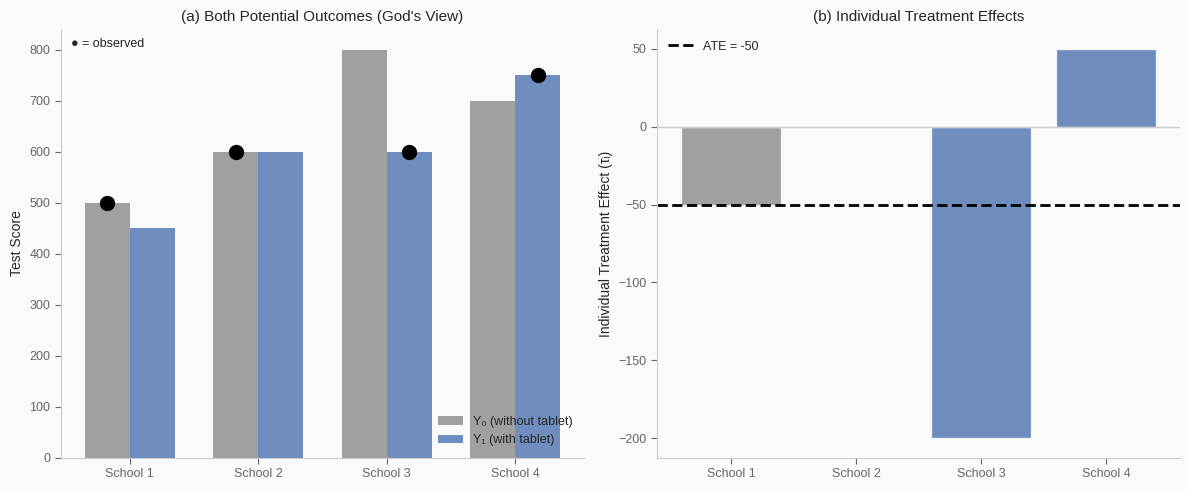

In [5]:
# Visualize the potential outcomes framework
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Panel 1: God's-eye view
ax = axes[0]
x = np.arange(4)
width = 0.35
ax.bar(x - width/2, schools['Y0'], width, label='Y₀ (without tablet)', 
       color=TUFTE_PALETTE['control'], alpha=0.8)
ax.bar(x + width/2, schools['Y1'], width, label='Y₁ (with tablet)', 
       color=TUFTE_PALETTE['treatment'], alpha=0.8)

# Mark which outcome is observed
for i, (t, y0, y1) in enumerate(zip(schools['T'], schools['Y0'], schools['Y1'])):
    if t == 0:
        ax.scatter(i - width/2, y0, s=100, c='black', marker='o', zorder=5)
    else:
        ax.scatter(i + width/2, y1, s=100, c='black', marker='o', zorder=5)

ax.set_xticks(x)
ax.set_xticklabels([f'School {i}' for i in range(1, 5)])
ax.set_ylabel('Test Score')
ax.set_title('(a) Both Potential Outcomes (God\'s View)')
ax.legend(frameon=False, loc='lower right')
ax.annotate('● = observed', xy=(0.02, 0.98), xycoords='axes fraction',
            ha='left', va='top', fontsize=9)

# Panel 2: Treatment effect visualization
ax = axes[1]
colors = [TUFTE_PALETTE['control'] if t == 0 else TUFTE_PALETTE['treatment'] 
          for t in schools['T']]
ax.bar(x, schools['tau_i'], color=colors, alpha=0.8, edgecolor='white')
ax.axhline(0, color=TUFTE_PALETTE['spine'], linestyle='-', linewidth=1)
ax.axhline(schools['tau_i'].mean(), color='black', linestyle='--', 
           linewidth=2, label=f'ATE = {schools["tau_i"].mean():.0f}')
ax.set_xticks(x)
ax.set_xticklabels([f'School {i}' for i in range(1, 5)])
ax.set_ylabel('Individual Treatment Effect (τᵢ)')
ax.set_title('(b) Individual Treatment Effects')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

---

## 4. Implementation

The potential outcomes framework is conceptual—it guides how we think about causal problems. Implementation involves *estimating* these quantities:

```python
# From causal_inference.rct.simple_ate
from causal_inference.rct.simple_ate import simple_ate

# Estimate ATE from observed data
result = simple_ate(
    outcome=data['score'],
    treatment=data['tablet']
)
```

The `simple_ate` function computes:
- Point estimate: $\hat{\text{ATE}} = \bar{Y}_1 - \bar{Y}_0$
- Standard error (Neyman formula)
- Confidence intervals

**Key**: The estimate is only valid under specific assumptions (see Section 02).

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"What is the fundamental problem of causal inference?"*

<details>
<summary>Solution</summary>

**Key points:**

1. **Definition**: We can never observe both potential outcomes $Y_0$ and $Y_1$ for the same unit.

2. **Why it matters**: The individual treatment effect $\tau_i = Y_{1i} - Y_{0i}$ requires both outcomes, so it's fundamentally unknowable.

3. **Not a data problem**: Even with infinite data, we can't see what *would have happened* to a specific individual under the alternative treatment.

4. **Resolution strategy**: 
   - Estimate *average* effects by comparing groups
   - Use randomization to make groups comparable
   - Use statistical adjustments when randomization isn't possible

5. **Example**: "If I took aspirin and my headache went away, did the aspirin help? I can't know for certain—maybe the headache would have gone away on its own."

</details>

---

**Q2 (Google L5, Econ)**: *"Explain the difference between ATE and ATT. When would you prefer one over the other?"*

<details>
<summary>Solution</summary>

**Definitions**:
- **ATE** = $E[Y_1 - Y_0]$: Average effect across the entire population
- **ATT** = $E[Y_1 - Y_0 | T=1]$: Average effect among those who *actually* received treatment

**When they differ**:
- **Heterogeneous treatment effects**: If treatment affects some people more than others
- **Selection into treatment**: If people who benefit most are more likely to take treatment

**When to use ATE**:
- Policy targeting: "If we mandated this for everyone, what would happen?"
- Universal programs: Education, public health interventions

**When to use ATT**:
- Program evaluation: "How much did this program help participants?"
- Voluntary programs: Job training, medical treatments with self-selection
- Cost-benefit: Calculate benefits for actual participants

**Example**: A job training program may help those who chose to enroll (high ATT) but wouldn't help everyone if mandatory (lower ATE).

</details>

---

**Q3 (Amazon L6, Applied Scientist)**: *"Why can't we just use machine learning to predict counterfactuals?"*

<details>
<summary>Solution</summary>

**The temptation**: Train ML model on treated outcomes, predict what control would have been (or vice versa).

**Why it fails**:

1. **No ground truth**: We never observe the counterfactual, so we can't validate predictions. ML needs labeled examples to learn from—but the "labels" (counterfactual outcomes) don't exist.

2. **Selection bias**: If treatment assignment depends on unobserved factors that also affect outcomes, predictions will be biased. ML can only extrapolate patterns in the training data.

3. **Distribution shift**: Predicting treated outcomes for control units requires extrapolating outside the training distribution—notoriously unreliable for ML.

**When ML CAN help**:
- **CATE estimation**: With proper causal assumptions (e.g., unconfoundedness), ML can estimate heterogeneous treatment effects (see Causal Forests, Meta-learners)
- **Nuisance parameter estimation**: In Double ML, ML predicts confounders to debias treatment effect estimates

**Key insight**: Prediction ≠ Causal inference. ML predicts $E[Y|X]$; causal inference estimates $E[Y_1 - Y_0]$.

</details>

---

## 6. References

[^1]: Holland, P. W. (1986). Statistics and Causal Inference. *Journal of the American Statistical Association*, 81(396), 945-960.

[^2]: Rubin, D. B. (1974). Estimating Causal Effects of Treatments in Randomized and Nonrandomized Studies. *Journal of Educational Psychology*, 66(5), 688-701.

[^3]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 1: Introduction to Causality.

[^4]: Imbens, G. W. and Rubin, D. B. (2015). *Causal Inference for Statistics, Social, and Biomedical Sciences*. Cambridge University Press, Chapters 1-2.

---

**Precision Improvement:**
- You said: "Build the potential outcomes notebook"
- Concise: "Build 01.1 potential outcomes"
- Precise: `/augmented 01.1 --po-notation --ite-ate-att`
- Pattern: [build] [chapter.section] [content-flags]